# Feature Selection
(by Tevfik Aytekin)

In feature election we try to find relevant features, that is, features which have an influence on the output. We will also try to quantify the influence of a feature. There are several ways we can find the relevance of features, in this notebook we will look at univariate filter methods. In other words, we will try to find the relevance of a single feature (independent of the others) on the output.


In [18]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import seaborn as sns
from sklearn.metrics import mutual_info_score
from sklearn.utils import resample
from scipy.stats import chisquare
from sklearn.feature_selection import chi2, SelectKBest, f_classif, f_regression
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from scipy.stats import chi2
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_classif



### Univariate Feature Selection
We will look at the pairwise relationships between the output variable and each one of the input variables. Our aim is to understand whether these pairs of variables are independent of each other or there is some kind of relationship between them. Different from visualizations, we will generate a numerical value for measuring the strength of the relationship.

We will use the following two datasets for illustration.
#### Example Datasets

In [2]:
# Bank Marketing Dataset from
# https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

bank = pd.read_csv("../datasets/bank/bank-full.csv", delimiter = ";")
bank.shape

(45211, 17)

In [3]:
# list random rows from the dataset
bank.iloc[np.random.randint(1,bank.shape[0],10),:] 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24826,36,technician,married,secondary,no,154,yes,no,cellular,18,nov,231,1,96,2,other,no
3150,57,technician,divorced,secondary,no,3105,yes,no,unknown,14,may,173,11,-1,0,unknown,no
6465,30,management,married,secondary,no,-397,yes,no,unknown,27,may,141,3,-1,0,unknown,no
3214,52,blue-collar,divorced,primary,no,-191,yes,no,unknown,15,may,755,1,-1,0,unknown,yes
27180,37,management,married,tertiary,no,489,yes,no,cellular,21,nov,202,1,106,5,failure,no
180,31,services,married,tertiary,no,37,yes,no,unknown,5,may,313,1,-1,0,unknown,no
23210,55,services,married,unknown,no,2944,no,no,cellular,27,aug,672,6,-1,0,unknown,yes
39457,35,technician,single,secondary,no,204,yes,no,cellular,25,may,236,1,-1,0,unknown,yes
28058,30,admin.,married,secondary,no,358,no,no,cellular,28,jan,156,2,-1,0,unknown,no
23590,44,technician,married,secondary,no,65,no,no,telephone,28,aug,53,11,-1,0,unknown,no


In [4]:
# load train.csv file from Kaggle "House Prices: Advanced Regression Techniques" dataset 
house = pd.read_csv("../datasets/house_prices/train.csv")
# print first 5 examples
house.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Case 1: Numerical Input vs. Numeric Output

For this type of analysis a common technique is to look at the correlation between the variables. There are three commonly used correlation measures: Pearson, Spearman, and Kendall. We will look at each in turn.


### Pearson correlation

Pearson correlation is a measure of linear relationship between two random variables X and Y. It is a scaled version of covariance (between -1 and 1); note that the two parameters always have the same sign (positive, negative, or 0). When the sign is positive, the variables are said to be positively correlated; when the sign is negative, the variables are said to be negatively correlated; and when the sign is 0, the variables are said to be uncorrelated. For basic statistical concepts like variance, covariance, and standard deviation check this [notebook](stats.ipynb).

$$pcorr(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

(0.9874100874179736, 7.282637065765987e-07)

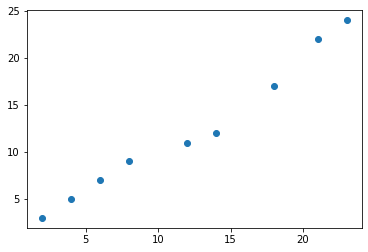

In [5]:
# Example
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 12, 17, 22, 24]

plt.plot(X,Y, "o")

# returns correlation and p-value
stats.pearsonr(X,Y)

### A note on p-value

P-value is an important statistical concept used in hypothesis testing. Technically, the p-value is the probability of observing a test statistic that is as extreme or more extreme than the observed test statistic under the null hypothesis. Intiutively, it means how likely it is to observe the sample by chance. If the p-value is small (typically less then 0.05) then we can reject the null hypothesis, that is, we can conclude that its very unlikely to observe the sample by chance.

For Pearson correlation the null hypothesis is that the samples come from uncorrelated normal distributed populations.

p-values are important when the sample sizes are small. Check out the sample below, the correlation is high but p-value > 0.05 which implies that the samples might come from uncorrelated populations. As a rule of thumb, you should ignore correlations which are not statistically significant (p > 0.05) even if the correlation is high.

(0.8944271909999159, 0.10557280900008414)

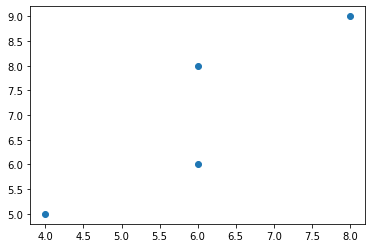

In [6]:
# Example
X = [6, 4, 6, 8] 
Y = [6, 5, 8, 9] 
plt.plot(X,Y, "o")

# returns correlation and p-value
stats.pearsonr(X,Y)

Below are some example datases with various degrees of Pearson correlation.

Question: Note that there is no correlation coefficient value for the dataset in the middle position. Why is that? Hint: Check the definition of correlation.

[image source](http://commons.wikimedia.org/wiki/File:Correlation_examples2.svg)

<img src="images/cor1.png" alt="drawing" width="500" align="left">


### <center>Anscombe's Quartet</center>

For all four datasets below the Pearson correlation coefficient is: +0.816.

<img src="images/cor2.png" alt="drawing" width="500" align="left">  


[image source](http://commons.wikimedia.org/wiki/File:Anscombe%27s_quartet_3.svg)  


#### Outlier Problem

Outliers might dratically influence the correlation values, so one should be careful with outliers in the evaluation of correlation results.

(0.0020896678072882535, 0.9957429791908522)

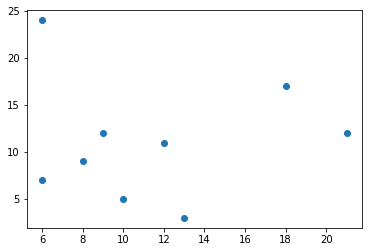

In [7]:
# Example
X = [13, 10, 6, 8, 12, 9, 18, 21, 6]
Y = [3, 5, 7, 9, 11, 12, 17, 12, 24]
plt.plot(X,Y, "o")
stats.pearsonr(X,Y)

(0.9632125532618062, 7.664333701501002e-06)

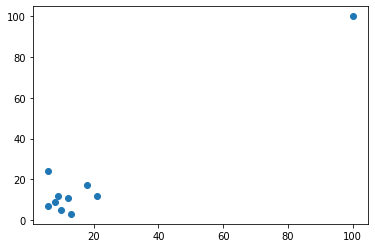

In [8]:
# After adding a single outlier
X = [13, 10, 6, 8, 12, 9, 18, 21, 6, 100]
Y = [3, 5, 7, 9, 11, 12, 17, 12, 24, 100]
plt.plot(X,Y, "o")
stats.pearsonr(X,Y)

### Spearman rank correlation
Spearman rank correlation is the Pearson correlation between the rank values of two variables.

<img src="images/spearman.png" style="max-width:100%; width: 40%" align="left">

[image source](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Spearman_fig1.svg/600px-Spearman_fig1.svg.png)

SpearmanrResult(correlation=1.0, pvalue=0.0)

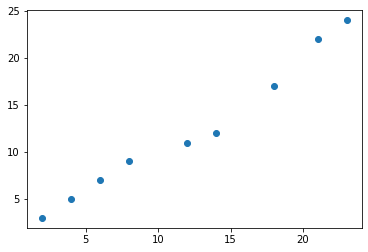

In [9]:
# Example
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 12, 17, 22, 24]

plt.plot(X,Y, "o")
stats.spearmanr(X,Y)

In [10]:
print(stats.rankdata(X))
print(stats.rankdata(Y))

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[1. 2. 3. 4. 5. 6. 7. 8. 9.]


SpearmanrResult(correlation=0.9833333333333333, pvalue=1.9361963037459243e-06)

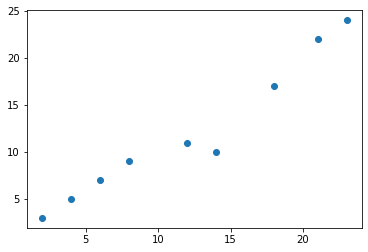

In [11]:
# Let us change the example a little
X = [2, 4, 6, 8, 12, 14, 18, 21, 23]
Y = [3, 5, 7, 9, 11, 10, 17, 22, 24]

plt.plot(X,Y, "o")
stats.spearmanr(X,Y)

In [12]:
X_ranks = stats.rankdata(X)
Y_ranks = stats.rankdata(Y)
print(X_ranks); print(Y_ranks)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[1. 2. 3. 4. 6. 5. 7. 8. 9.]


In [13]:
stats.pearsonr(X_ranks,Y_ranks)

(0.9833333333333333, 1.936196303745927e-06)

### Kendall Rank Correlation

In [14]:
def kendall_tau(x,y):
    concordant = 0
    discordant = 0
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if ((x[i]-x[j]) * (y[i]-y[j])) > 0:
                concordant += 1
            else:
                discordant += 1
    return (concordant-discordant)/(concordant+discordant)

KendalltauResult(correlation=0.7777777777777777, pvalue=0.0009463183421516755)

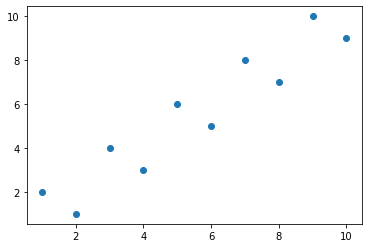

In [15]:
X = [1,2,3,4,5,6,7,8,9,10]
Y = [2,1,4,3,6,5,8,7,10,9]
plt.plot(X,Y, "o")
stats.kendalltau(X,Y)

In [16]:
kendall_tau(X,Y)

0.7777777777777778

### SelectKBest

We can use SelectKBest to find features with the highest scores.

In [19]:
X = house.select_dtypes(include=np.number) # select numeric columns
X = X.drop("SalePrice", axis=1)
y = house.loc[:,'SalePrice']
X = X.fillna(X.mean())

selector = SelectKBest(f_regression, k=4)
selector.fit(X, y);

In [20]:
sorted_idx = np.argsort(selector.scores_)[::-1]
sorted_vals = np.sort(selector.scores_)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals, "p-values":selector.pvalues_[sorted_idx]}
df = pd.DataFrame(d)
df

,features,values,p-values
0,OverallQual,2436.770591,2.185675e-313
1,GrLivArea,1470.585010,4.518034e-223
2,GarageCars,1013.705666,2.498644e-169
3,GarageArea,926.951287,5.265038e-158
4,TotalBsmtSF,880.341282,9.484229e-152
5,1stFlrSF,845.524488,5.394711e-147
6,FullBath,668.430296,1.236470e-121
7,TotRmsAbvGrd,580.762801,2.772281e-108
8,YearBuilt,548.665821,2.990229e-103
9,YearRemodAdd,504.714855,3.164948e-96


The values shown are not Pearson correlation values but instead F-statistic which is calculated as follows:

$$
\frac{r^2}{1-r^2}*(n-2)
$$

where $r$ is the Pearson correlation, and $n$ is the number of examples. As shown in the following figure since this is a strictly growing function between -1 and 1, the order of the features is the same as $r$.

/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


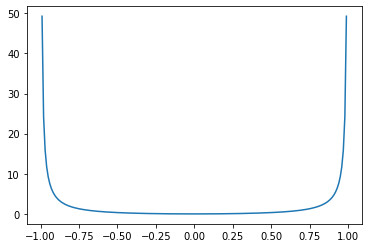

In [21]:
x = np.arange(-1,1,0.01)
y = x**2/(1-x**2)
plt.plot(x,y)

# Case 2: Numerical Input vs. Categorical Output


Now we will try to see if a numerical feature is relevant for a categorical class variable. One thing we can do is to look at the distribution of the numerical variable grouped by each value of the categorical variable. If the categorical and numerical variables are independent then we expect to see a similar distribution of the values of the numerical variable for each value of the categorical variable (i.e., the grouping of the numerical variable by the values of the categorical variable should not create any difference). But if the distributions are not similar then we may say that the numerical variable is relevant and also as the dissimilarity of the distributions increase it is reasonable to assume that the relevancy also increases. Of course we need some formula to measure similarity of distributions. Note that there can be two or more distributions. So our measure should work for two or more distributions. One such measure is Anova F-value.

F-statistic is a way of measuring the difference between sample distributions which is defined below. Further below you will find the implementation.

$$ F = \frac{Variation\: between\: sample\: means}{Variation\: witin\: the\: samples} $$


**Look at the following figures and try to answer this question: are these groups come from the same population or not? How can we measure this probability, that is, the probability of coming form the same distribution?**

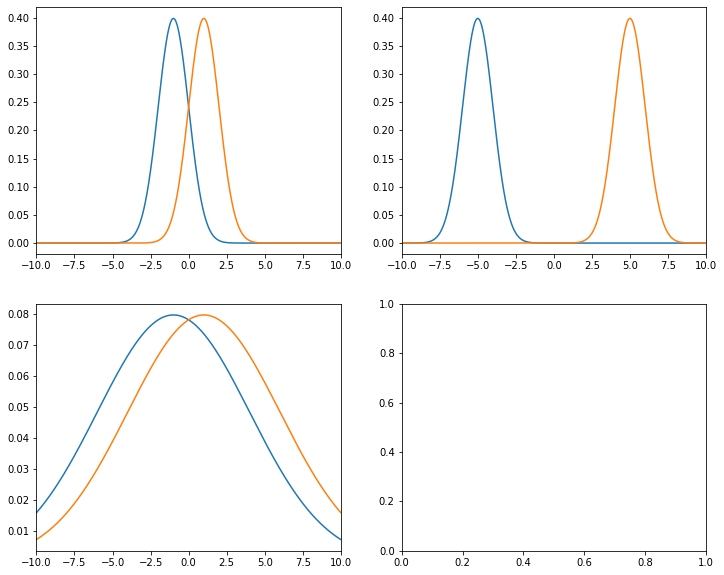

In [22]:
f, ax = plt.subplots(2,2)
ax[0,0].set_xlim(-10,10)
f.set_size_inches(12,10)

x = np.arange(-10, 10, 0.01)
sns.lineplot(x=x, y=stats.norm.pdf(x,-1,1), ax= ax[0,0])
sns.lineplot(x=x, y=stats.norm.pdf(x,1,1), ax= ax[0,0])

ax[0,1].set_xlim(-10,10)
sns.lineplot(x=x, y=stats.norm.pdf(x,-5,1), ax= ax[0,1])
sns.lineplot(x=x, y=stats.norm.pdf(x,5,1), ax= ax[0,1])

ax[1,0].set_xlim(-10,10)
sns.lineplot(x=x, y=stats.norm.pdf(x,-1,5), ax= ax[1,0])
sns.lineplot(x=x, y=stats.norm.pdf(x,1,5), ax= ax[1,0])


# Mean = 0, Std = 2. You can play wth these parameters.


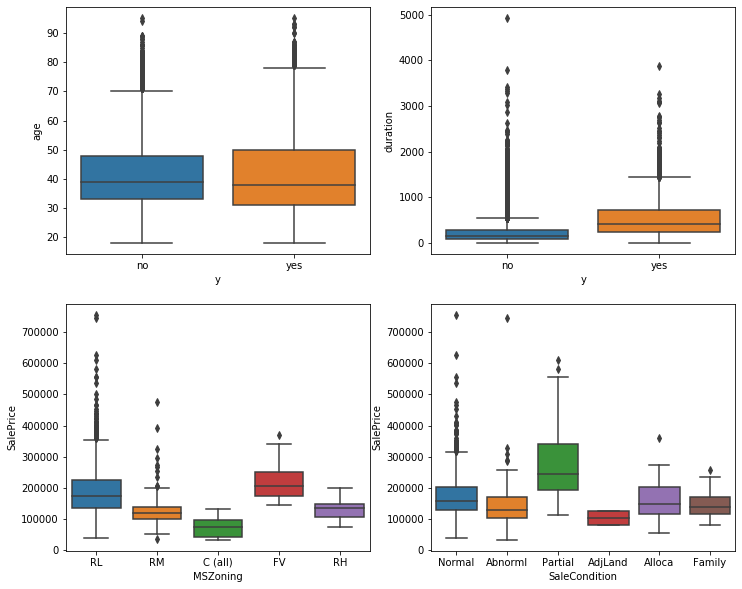

In [23]:
f, ax = plt.subplots(2,2)
f.set_size_inches(12,10)
sns.boxplot(y="age", x="y", data= bank, ax = ax[0,0]);
sns.boxplot(y="duration", x="y", data= bank, ax = ax[0,1]);
sns.boxplot(x="MSZoning", y="SalePrice", data= house, ax = ax[1,0]);
sns.boxplot(x="SaleCondition", y="SalePrice", data= house, ax = ax[1,1]);


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa36833d710>,
      dtype=object)

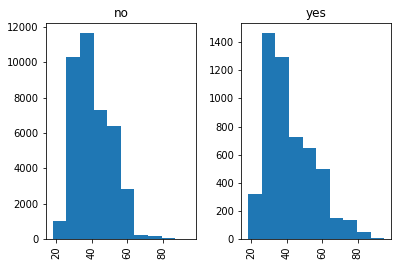

In [24]:
bank["age"].hist(by=bank["y"])

Below is the result of one-way anova test. As can be seen the result is statistically significant, so smaller age indeeds affects the result in the positive way, however, what is the size of this affect? If we look at the above plots the distribution of ages are not that much different, fvalue is t


In [25]:
group1 = bank[bank["y"]=="yes"].age
group2 = bank[bank["y"]=="no"].age
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)


28.625233091728465 8.825643691900577e-08


Let us calculate the f-value from scratch.

In [26]:
def f_statistic(*groups):
    
    merged_groups = np.concatenate(groups)
    grand_mean = np.mean(merged_groups)
    ss_total = sum((merged_groups - grand_mean)**2)    
    group_means = [np.mean(g) for g in groups]
    ss_within = 0
    ss_between = 0
    for i in range(len(groups)):
        x = groups[i] - group_means[i]
        ss_within += np.sum((groups[i] - group_means[i])**2)
        ss_between += groups[i].size * (group_means[i] - grand_mean)**2
        
    df1 = len(groups) - 1
    df2 = merged_groups.size - len(groups)
    f_stat = (ss_between / df1) / (ss_within / df2)
    
    #print(ss_between / df1)
    #print(ss_within / df2)
    #print(ss_total," ",ss_within," ", ss_between)
    #print(ss_within + ss_between)
    #print(f_statistic)
    
    return f_stat

In [27]:
group1 = bank[bank["y"]=="yes"].age.values
group2 = bank[bank["y"]=="no"].age.values
f_statistic(group1, group2)


28.62523309172829

/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


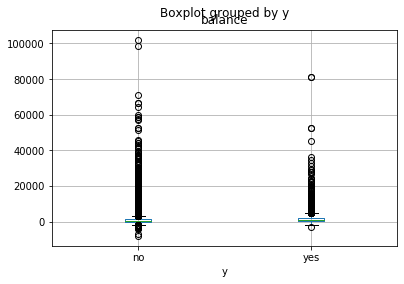

In [28]:
bank.boxplot(column=["balance"], by="y")

/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


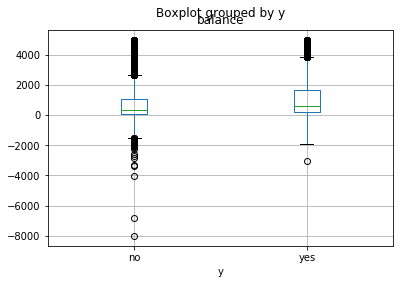

In [29]:
bank2 = bank[(bank.balance < 5000)]
bank2.boxplot(column=["balance"], by="y")

In [30]:
group1 = bank[bank["y"]=="yes"].balance
group2 = bank[bank["y"]=="no"].balance
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)

126.57227551143087 2.5211136918594683e-29


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


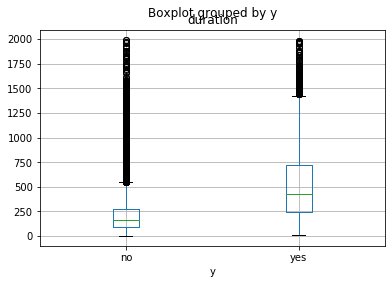

In [31]:
bank2 = bank[(bank.duration < 2000)]
bank2.boxplot(column=["duration"], by="y")

In [32]:
group1 = bank[bank["y"]=="yes"].duration
group2 = bank[bank["y"]=="no"].duration
fvalue, pvalue = stats.f_oneway(group1, group2)
print(fvalue, pvalue)

8333.761148332413 0.0


### SelectKBest

We can use SelectKBest to find features with the highest scores.

In [33]:
X = bank.loc[:,'age':'poutcome']
X = bank.select_dtypes(include=np.number) # select numeric columns

y = bank.loc[:,'y']
y = y.replace(["yes","no"],[1,-1])
selector = SelectKBest(f_classif, k=4)
selector.fit(X, y)

SelectKBest(k=4, score_func=<function f_classif at 0x7fa366f0ed40>)

In [34]:
sorted_idx = np.argsort(selector.scores_)[::-1]
sorted_vals = np.sort(selector.scores_)[::-1]

d = {"features":X.columns[sorted_idx], "values":sorted_vals, "p-values":selector.pvalues_[sorted_idx]}
df = pd.DataFrame(d)
df

,features,values,p-values
0,duration,8333.761148,0.000000e+00
1,pdays,490.696563,3.790553e-108
2,previous,396.443989,7.801830e-88
3,campaign,243.358404,1.012347e-54
4,balance,126.572276,2.521114e-29
5,day,36.359010,1.653880e-09
6,age,28.625233,8.825644e-08


### More than two groups

/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


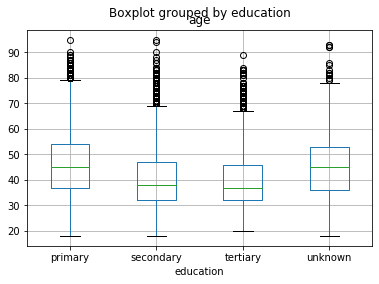

In [35]:
bank.boxplot(column=["age"], by="education")

In [36]:
group1 = bank[bank["education"]=="primary"].age
group2 = bank[bank["education"]=="secondary"].age
group3 = bank[bank["education"]=="tertiary"].age
group4 = bank[bank["education"]=="unknown"].age

fvalue, pvalue = stats.f_oneway(group1, group2, group3, group4)
print(fvalue, pvalue)

731.7577454812724 0.0


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


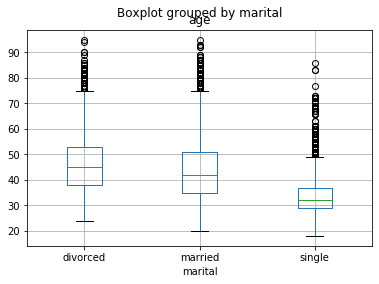

In [37]:
bank.boxplot(column=["age"], by="marital")

In [38]:
group1 = bank[bank["marital"]=="single"].age
group2 = bank[bank["marital"]=="married"].age
group3 = bank[bank["marital"]=="divorced"].age


fvalue, pvalue = stats.f_oneway(group1, group2, group3)
print(fvalue, pvalue)

5228.732920484922 0.0


# Case 3: Categorical Input vs. Numerical Output

Actually this case is essentially the same as case 3, so we can use F-value.


# Case 4: Categorical Input vs. Categorical Output

When the input feature is categorical and the class is also categorical, the most common measures used are chi-square test and mutual information.


## Chi Square Test

As an example let us consider if there is a relationship between marital status and the class y for the banking dataset. Chi-square test relies on a contingency table. 

In [39]:
group1 = np.unique(bank.y)
group2 = np.unique(bank.marital)
con_table = np.zeros((len(group1),len(group2)))
for i in range(len(group1)):
    for j in range(len(group2)):
        con_table[i][j] = sum((bank.y == group1[i]) & (bank.marital == group2[j]))

In [40]:
def calc_contingency_table(df, a1, a2):
    group1 = np.unique(df[a1])
    group2 = np.unique(df[a2])
    con_table = np.zeros((len(group1),len(group2)))
    for i in range(len(group1)):
        for j in range(len(group2)):
            con_table[i][j] = sum((df[a1] == group1[i]) & (df[a2] == group2[j]))
    return con_table, group1, group1

In [41]:
x,a,b = calc_contingency_table(bank,"y","marital")
print(a)

['no' 'yes']


In [42]:
con_table

array([[ 4585., 24459., 10878.],
       [  622.,  2755.,  1912.]])

In [43]:
stats.chi2_contingency(con_table)

(196.4959456560396,
 2.1450999986791486e-43,
 2,
 array([[ 4597.86012254, 24030.37552808, 11293.76434938],
        [  609.13987746,  3183.62447192,  1496.23565062]]))

In [44]:
def calc_chi2_contingency(con_table):
    con_table = con_table.astype(float)
    expected_arr = np.zeros((con_table.shape[0],con_table.shape[1]))
    marginals_col = con_table.sum(axis=0)
    marginals_row = con_table.sum(axis=1)
    total = con_table.sum()
    for i in range(con_table.shape[0]):
        for j in range(con_table.shape[1]):
            expected = (marginals_row[i]) * (marginals_col[j]) / total
            con_table[i][j] = ((con_table[i][j] - expected)**2) / expected
            expected_arr[i][j] = expected
    #print(expected_arr)
    return con_table.sum()

In [45]:
chi2_stat = calc_chi2_contingency(con_table)
chi2_stat

196.4959456560396

In [46]:
def mutual_info(df, a1, a2):
    con_table = calc_contingency_table(df, a1, a2)
    print(con_table)
    marginals_col = con_table.sum(axis=0)
    marginals_row = con_table.sum(axis=1)
    total = con_table.sum()
    mi = 0
    for i in range(con_table.shape[0]):
        for j in range(con_table.shape[1]):
            p = con_table[i][j] / total
            print(i," ", j," ", p)

            m = (marginals_row[i] / total)*(marginals_col[j] / total)
            
            if (p > 0):
                mi += p*np.log(p / m)
            
    return mi

In [ ]:
mutual_info(bank,"y","marital")

In [48]:
H_x = H_y = -(3/5) * np.log(3/5) - (2/5) * np.log(2/5)
H_xy = -1/5 * np.log(1/5) - 2/5 * np.log(2/5) - 2/5 * np.log(2/5)
I_xy = H_x + H_y - H_xy
I_xy

0.29110316603236885

In [49]:
a = np.array([0,1,1, 0, 0])
b = np.array([1, 0, 0, 0, 1])
print(mutual_info_score(a, b))

0.2911031660323686


In [50]:
df = pd.DataFrame({"a":[0,1,1, 0, 0], "b":[1, 0, 0, 0, 1]}, columns = ["a","b"])
df

,a,b
0,0,1
1,1,0
2,1,0
3,0,0
4,0,1


In [ ]:
mutual_info(df,"a","b")

In [52]:
X = bank.loc[:,['marital', 'y']]
X = pd.get_dummies(X)
y = bank.loc[:,'y']
importances_mi = mutual_info_classif(X, y)
importances_mi

array([6.16978557e-05, 4.67116793e-03, 4.17401410e-03, 3.69146387e-01,
       3.61073130e-01])

In [ ]:
mi = mutual_info(X,"y_yes","y_no")
print(mi)

In [54]:
calc_contingency_table(X,"y_yes","marital_divorced")

(array([[35337.,  4585.],
        [ 4667.,   622.]]),
 array([0, 1], dtype=uint8),
 array([0, 1], dtype=uint8))

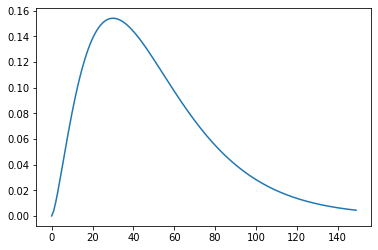

In [55]:
plt.plot(chi2.pdf(np.arange(0.0,15,0.1),5))

In [56]:
chi2.pdf(chi2_stat,2) ## df ???

1.0725499993395723e-43

In [57]:
x = [2, 4, 6]

# Categorical (nominal), Ordinal, and Numerical Variables

https://stats.idre.ucla.edu/other/mult-pkg/whatstat/what-is-the-difference-between-categorical-ordinal-and-numerical-variables/